In [1]:
import os
import random
import json
import hashlib
import numpy as np
import pandas as pd
import xarray
import neptune
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from tqdm import tqdm as tqdm
import multiprocessing as mp

from sklearn.linear_model import LinearRegression,Ridge,RidgeCV

import brainscore
from brainscore.assemblies import walk_coords,split_assembly
from brainscore.assemblies import split_assembly
from brainscore.metrics import Score

from brainio_base.assemblies import DataAssembly

from scipy.stats import pearsonr

from src.results.experiments import _DateExperimentLoader
from src.results.utils import raw_to_xr, dprime
from src.results.neptune import get_model_files, load_models, load_assemblies, load_params, load_properties,prep_assemblies
from src.results.dicarlo import get_dicarlo_su
from src.data_loader import Shifted_Data_Loader

def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("talk")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Georgia","Times New Roman", "Palatino", "serif"]
    })

Using TensorFlow backend.


In [2]:
os.environ['NEPTUNE_API_TOKEN']="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiI3ZWExMTlmYS02ZTE2LTQ4ZTktOGMxMi0wMDJiZTljOWYyNDUifQ=="
neptune.init('elijahc/DuplexAE')
neptune.set_project('elijahc/DuplexAE')

Project(elijahc/DuplexAE)

In [3]:
proj_root = '/home/elijahc/projects/vae'

In [4]:
def load_config(exps):
    props = load_properties(exps)
    params = load_params(exps)
    ids = [e.id for e in exps]
    for eid,pr,pa in zip(ids,props,params):
        out = {'id':eid}
        out.update(pr)
        out.update(pa)
        out['exp_dir']=os.path.join(proj_root,pr['dir'])
        yield out

In [5]:
conv_eids = [
    'DPX-64',
    'DPX-65',
]
conv_exps = neptune.project.get_experiments(id=conv_eids)
# dense_exps = neptune.project.get_experiments(id=dense_eids)
exps = np.array(conv_exps)
s_df = pd.DataFrame(list(load_config(exps)))
s_df

,augmentation,batch_sz,bg,bg_contrast,dataset,dir,encoder_arch,exp_dir,generator_arch,id,im_translation,n_epochs,recon_weight,rotation,xent_weight,y_dim,z_dim
0,dynamic,256.0,natural,0.5,fashion_mnist,models/2020-05-28/DPX-64,convnet,/home/elijahc/projects/vae/models/2020-05-28/D...,resnet,DPX-64,0.75,90000.0,1.0,0.3,15.0,500.0,0.0
1,dynamic,256.0,natural,0.5,fashion_mnist,models/2020-05-28/DPX-65,convnet,/home/elijahc/projects/vae/models/2020-05-28/D...,N/A,DPX-65,0.75,180000.0,0.0,0.3,15.0,500.0,0.0


In [12]:
recon_idxs = (s_df.recon_weight > 0).values
nrecon_idxs = ~recon_idxs

In [13]:
recon = exps[recon_idxs]
nrecon = exps[nrecon_idxs]

In [6]:
def fetch_experiment_channels(exps,channels,merge_cols=['id','encoder_arch']):
    for i,exp in enumerate(exps):
        conf = s_df.iloc[i]
#         print(conf)
        df = exp.get_numeric_channels_values(*channels)
        for c in merge_cols:
            df[c]= conf[c]
        yield df

In [7]:
channels = pd.concat(fetch_experiment_channels(exps,['val_acc','C_loss','val_G_loss'],merge_cols=['id','encoder_arch','recon_weight']))

In [15]:
recon_acc = pd.concat(fetch_experiment_channels(recon,['val_acc','C_loss','val_G_loss']))
recon_acc['model'] = 'with-recon'

nrecon_acc = pd.concat(fetch_experiment_channels(nrecon,['val_acc','C_loss','val_G_loss']))
nrecon_acc['model'] = 'classify-only'

acc = pd.concat([recon_acc,nrecon_acc])

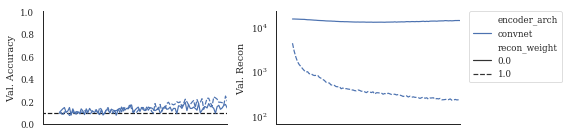

In [16]:
set_style()
sns.set_context('paper')
fig,axs = plt.subplots(1,2,figsize=(8,2),sharex=True)

sns.lineplot(x='x',y='val_acc',hue='encoder_arch',style='recon_weight',data=channels,ax=axs[0],
            legend=False,
            )
axs[0].set_ylim(0,1)
axs[0].hlines(y=0.1,xmin=-11,xmax=500,linestyles='dashed')

sns.lineplot(x='x',y='val_G_loss',hue='encoder_arch',style='recon_weight',data=channels,ax=axs[1],
#              legend=False,
            )
axs[1].set_yscale('log')
# axs[1].set_ylim(0,1000)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


axs[0].set_xlim(-10,100)
axs[0].get_xaxis().set_visible(False)
axs[1].get_xaxis().set_visible(False)
axs[0].set_ylabel('Val. Accuracy')
axs[1].set_ylabel('Val. Recon')

sns.despine(fig)
plt.tight_layout()

In [34]:
channels['time'] = pd.to_timedelta(channels.x.values*1000000000)

In [41]:
channels.resample('1T',on='time').mean().head()

,x,val_acc,val_G_loss,C_loss,recon_weight
time,,,,,
00:00:00,29.5,0.121289,7136.943993,2.503834,0.5
00:01:00,89.5,0.172982,6985.640193,2.265358,0.5
00:02:00,149.5,0.219954,7520.370713,2.199062,0.5
00:03:00,209.5,0.276986,7767.022577,2.094163,0.5
00:04:00,269.5,0.326823,7955.645693,2.000516,0.5


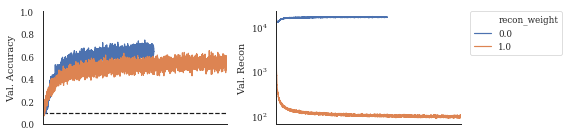

In [50]:
set_style()
sns.set_context('paper')
fig,axs = plt.subplots(1,2,figsize=(8,2),sharex=True)

sns.lineplot(x='x',y='val_acc',
#              style='encoder_arch',
             hue='recon_weight',
             data=channels,ax=axs[0],
            legend=False,
            )
axs[0].set_ylim(0,1)
axs[0].hlines(y=0.1,xmin=-11,xmax=6000,linestyles='dashed')

sns.lineplot(x='x',y='val_G_loss',
#              style='encoder_arch',
             hue='recon_weight',
             data=channels,ax=axs[1],
#              legend=False,
            )
axs[1].set_yscale('log')
# axs[1].set_ylim(0,1000)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

axs[0].set_xlim(-10,6000)
axs[0].get_xaxis().set_visible(False)
axs[1].get_xaxis().set_visible(False)
axs[0].set_ylabel('Val. Accuracy')
axs[1].set_ylabel('Val. Recon')

sns.despine(fig)
plt.tight_layout()

In [51]:
fig.savefig('../figures/pub/neural_networks/val_acc_recon.pdf',dpi=300)

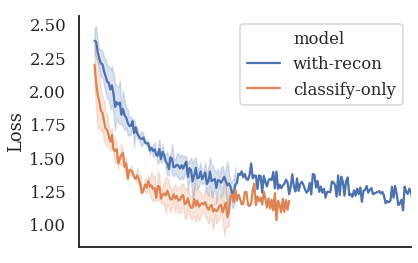

In [13]:
set_style()
sns.set_context('talk')
fig,ax = plt.subplots(1,1)

sns.lineplot(x='x',y='C_loss',hue='model',data=acc,ax=ax)
# ax.hlines(y=0.1,xmin=-11,xmax=500,linestyles='dashed')

ax.set_xlim(-10,200)
ax.get_xaxis().set_visible(False)
ax.set_ylabel('Loss')
sns.despine(fig)
plt.tight_layout()

In [14]:
# fig.savefig('../figures/sfn/model_loss.pdf',dpi=300)

In [15]:
def load_su(exp_dirs,fn='su_selectivity'):
    merge_cols = ['augmentation','encoder_arch','recon_weight','xent_weight','dir']
    for i,d in enumerate(exp_dirs):
        conf = s_df.iloc[i]
        filenames = filter(lambda i: i.startswith('su_selec'), os.listdir(d))
        filepaths = [os.path.join(d,fn) for fn in filenames]
        for j,fp in enumerate(filepaths):
            if os.path.exists(fp):
                df = pd.read_parquet(fp)
                if len(filepaths) > 1:
                    df['sample']=j+1
                for c in merge_cols:
                    df[c]= conf[c]
                yield df
            else:
                asdf

In [16]:
s_df.query('encoder_arch == "convnet"').exp_dir

0    /home/elijahc/projects/vae/models/2019-11-04/D...
1    /home/elijahc/projects/vae/models/2019-11-04/D...
Name: exp_dir, dtype: object

In [17]:
s_df.query('encoder_arch == "dense" & augmentation == "dynamic"').exp_dir.values

array(['/home/elijahc/projects/vae/models/2019-09-25/DPX-10',
       '/home/elijahc/projects/vae/models/2019-09-25/DPX-16'],
      dtype=object)

In [18]:
sus = list(load_su(s_df.exp_dir.values))
su_df = pd.concat(sus)

su_conv_df = su_df.query('encoder_arch == "convnet"').dropna(axis=1)

# sud = list(load_su(s_df.query('encoder_arch == "dense" & augmentation == "dynamic"').exp_dir.values))
su_dense_df = su_df.query('encoder_arch == "dense" & augmentation == "dynamic"').dropna(axis=1)

/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [19]:
su_conv_df.groupby('region').count()

,augmentation,category,dir,encoder_arch,layer,recon_weight,sample,tx,ty,xent_weight
region,,,,,,,,,,
conv_1,1152,1152,1152,1152,1152,1152,1152,1152,1152,1152
conv_2,1152,1152,1152,1152,1152,1152,1152,1152,1152,1152
conv_3,1152,1152,1152,1152,1152,1152,1152,1152,1152,1152
conv_4,1152,1152,1152,1152,1152,1152,1152,1152,1152,1152
pixel,9408,9408,9408,9408,9408,9408,9408,9408,9408,9408
y_enc,210,210,210,210,210,210,210,210,210,210
z_enc,210,210,210,210,210,210,210,210,210,210


In [20]:
su_dense_df.groupby(['dir','recon_weight']).count()

,,augmentation,category,encoder_arch,layer,region,sample,tx,ty,xent_weight
dir,recon_weight,,,,,,,,,
models/2019-09-25/DPX-10,1.0,11412,11412,11412,11412,11412,11412,11412,11412,11412
models/2019-09-25/DPX-16,0.0,15118,15118,15118,15118,15118,15118,15118,15118,15118


In [21]:
# sus[0].drop(columns=['reg']).to_parquet(os.path.join(s_df.exp_dir.values[0],'su_selectivity.pqt'))

In [22]:
dicarlo_df = get_dicarlo_su(proj_root,fn='su_selectivity_dicarlo_hi_var.pqt')
dicarlo_df = dicarlo_df.fillna(0)

In [23]:
# DL = Shifted_Data_Loader('fashion_mnist',rotation=None,translation=0.75,bg='natural',flatten=False)
# sx_test = DL.sx_test

In [24]:
# plt.imshow(sx_test[250].reshape(56,56),cmap='gray')

In [25]:
# neural_data = brainscore.get_assembly(name="dicarlo.Majaj2015")
# neural_data.load()
# stimulus_set = neural_data.attrs['stimulus_set']

In [26]:
# hi_data = process_dicarlo(neural_data,variation=6)

In [27]:
# sns.set(font_scale=2)
# sns.set_context('paper')

In [28]:
from src.results.dicarlo import err_neuroids

In [29]:
len(dicarlo_df)

6849

In [30]:
len(dicarlo_df[~dicarlo_df.neuroid_id.isin(err_neuroids)])

6809

In [31]:
dicarlo_df = dicarlo_df[~dicarlo_df.neuroid_id.isin(err_neuroids)]

In [32]:
def topn_su_decode(df,n,props,plot_fn,**kwargs):
    order=[0,1,2,3,4,5]
    fig,axs = plt.subplots(2,3,figsize=(9,8),sharey='row',**kwargs)
    set_style()
    sns.set_context('talk')
    for ax,prop in zip(axs.ravel(),props):
        pix = [df.query('layer == 0')]
        df_topn = pd.concat(pix+[df.query('layer == {}'.format(l)).nlargest(n,prop) for l in [1,2,3,4]])
        plot_fn(x='layer',y=prop,order=order,data=df_topn,ax=ax,palette='magma')
        ax.set_xticklabels(['pix','V1','V2','V4','IT','?'])
#         ax.set_ylabel('d\'')
        ax.set_ylabel('')
        ax.set_title(prop)
        sns.despine(ax=ax)
        
    del_ax = axs.ravel()[2]
    del_ax.clear()
    del_ax.get_xaxis().set_visible(False)
    plt.tight_layout()
    return fig,axs


props = ['category_name','object_name','object_name','tx','ty','rxy']
new_prop_names = ['Category', 'Identity', 'Identity','X Position','Y Position','Rotation (xy)']
dicarlo_df = dicarlo_df.rename(columns={k:v for k,v in zip(props,new_prop_names)})

fig,axs = topn_su_decode(dicarlo_df,n=192,
                         props=new_prop_names,
                         plot_fn=sns.boxplot,
#                subplot_kw={'ylim':(0,0.5)},
              )

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f40a6bef268> (for post_execute):


KeyboardInterrupt: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error in callback <function flush_figures at 0x7f40a6bfbbf8> (for post_execute):
Traceback (most recent call last):
  File "/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/IPython/core/events.py", line 88, in trigger
    func(*args, **kwargs)
  File "/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/ipykernel/pylab/backend_inline.py", line 117, in flush_figures
    return show(True)
  File "/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/ipykernel/pylab/backend_inline.py", line 39, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/IPython/core/display.py", line 304, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "</home/elijahc/.pyenv/versions/fastai/lib

KeyboardInterrupt: 

In [33]:
# fig.savefig('../figures/dicarlo_su_all.pdf',dpi=300)

KeyboardInterrupt: 

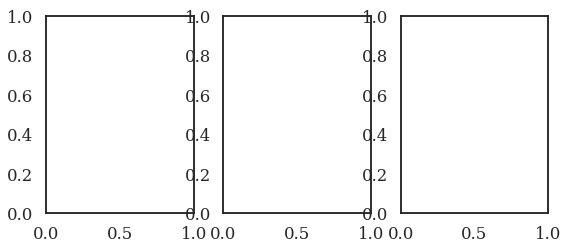

In [34]:
fig,axs = topn_su_decode(dicarlo_df,n=25,
                         props=new_prop_names,
                         plot_fn=sns.boxplot,
#                subplot_kw={'ylim':(0,0.5)},
              )

In [ ]:
fig.savefig('../figures/dicarlo_su_top25.pdf',dpi=300)

In [ ]:
fig,axs = topn_su_decode(dicarlo_df,n=25,
                         props=new_prop_names,
                         plot_fn=sns.barplot,
#                subplot_kw={'ylim':(0,0.5)},
              )
axs[0,0].set_ylim(0,0.8)
axs[1,0].set_ylim(0,0.4)
fig.savefig('../figures/dicarlo_su_top25_barplot.pdf',dpi=300)

In [ ]:
# convnet = [
#     aug_df.query('augmentation == "dynamic" & recon_weight == 0.0'),
#     aug_df.query('augmentation == "dynamic" & recon_weight == 1.0')
# ]
# single = [
#     aug_df.query('augmentation == "single" & recon_weight == 0.0'),
#     aug_df.query('augmentation == "single" & recon_weight == 1.0')
# ]

In [ ]:
set_style()

In [ ]:
sns.set_context('talk')

In [ ]:
dicarlo_df = dicarlo_df.rename(columns={'X Position':'tx','Y Position':'ty','Rotation (xy)':'rxy','Identity':'identity_name','Category':'category_name'})

In [ ]:
conv_x_orders = {
    'region':(
        ['pixel','conv_2','conv_3','conv_4','y_enc','z_enc'],
        ['pix','Layer 2','Layer 3','Layer 4',r'$L_2$',r'$L_1$']
    ),
    'layer':(
        [0,2,3,4,5],
        ['pix','C2','C3','C4','L'],
    )
}
macaque_x_conf = {
    'layer':(
        [0,1,2,3,4,5],
        ['pix','V1','V2','V4','IT','?']
    ),
    'subregion':(
        ['pixel','V1','V2','V4','aIT','cIT','pIT'],
        ['pixel','V1','V2','V4','aIT','cIT','pIT']
    )
}
dense_x_conf = {
    'region':(
        ['pixel','dense_1','dense_2','dense_3','y_lat','z_lat'],
        ['pix','D1','D2','D3','L2','L1']
    ),
    'layer':(
        [0,1,2,3,4],
        ['pix','D1','D2','D3','L']
    )
}

def plot_row(df,props,axs,plot_fn=sns.barplot,x_conf=conv_x_orders,row_title='with_recon',topn=None,x='region'):
    for i,ax,prop in zip(np.arange(len(props)),axs,props):
        x_order,x_labels = x_conf[x]
        if topn is not None:
            topn_l = [df.query('{} == {}'.format(x,l)).nlargest(topn,prop) for l in x_order[1:]]
            topn_l = [df.query('{} == {}'.format(x,x_order[0]))]+topn_l
            plot_df = pd.concat(topn_l) 
        else:
            plot_df = df
        
        
        plot_fn(x=x,y=prop,order=x_order,data=plot_df,ax=ax,palette='magma')
        ax.set_xticklabels(x_labels)
#         ax.set_xticklabels()
#         plt.xticks(rotation=45)
    #         ax.set_ylabel('d\'')
        if i == 0:
            ax.set_ylabel(row_title)
        else:
            ax.set_ylabel('')
        ax.set_title(prop)
        sns.despine(ax=ax)

# Convolutional Architecture

In [ ]:
_,xlab = conv_x_orders['region']
xlab

In [ ]:
sns.palplot(sns.light_palette("green", 5))

In [ ]:
sns.palplot(sns.light_palette("red", 5))

In [ ]:
sns.palplot(sns.light_palette("blue", 5))

In [ ]:
sns.palplot(sns.light_palette("yellow", 5))

In [ ]:
np.linspace(0,3,num=5)

In [ ]:
sns.palplot(sns.cubehelix_palette(5,start=0))

In [ ]:
sns.palplot(sns.cubehelix_palette(5,start=.75))

In [ ]:
sns.palplot(sns.cubehelix_palette(5,start=1.5))

In [ ]:
props = ['category','tx','ty']
# mod_order = [0,2,3,4,5]
n_rows = 3
n_cols = 3
fig,axs = plt.subplots(n_rows,n_cols,figsize=(n_cols*4,n_rows*4),sharey='col')
plot_fn = sns.boxplot
#     sns.set_context('talk')

plot_row(dicarlo_df,['category_name','tx','ty'],axs[0],x_conf=macaque_x_conf,row_title='Macaque',
         topn=25,x='layer',
         plot_fn=sns.barplot)
    
df = su_conv_df.query('sample == 1 & recon_weight > 0')
plot_row(df,['category','tx','ty'],axs[1],row_title='with-recon',x='region',plot_fn=sns.barplot)
for ax in axs[1]:
    _,xlab = conv_x_orders['region']
    ax.set_xticklabels(labels=xlab,rotation=45)
  
df = su_conv_df.query('sample == 1 & recon_weight == 0')
plot_row(df,['category','tx','ty'],axs[2],row_title='classify-only',x='region',plot_fn=sns.barplot)
for ax in axs[2]:
    _,xlab = conv_x_orders['region']
    ax.set_xticklabels(xlab,rotation=45)

axs[0,0].set_ylim(0,1.0)
axs[0,1].set_ylim(0,0.35)
axs[0,2].set_ylim(0,0.35)

plt.tight_layout()

In [ ]:
os.makedirs('../figures/pub')

In [ ]:
fig.savefig('../figures/pub/conv_plots.pdf',dpi=300)

# Dense Architecture

In [ ]:
props = ['category','tx','ty']
# mod_order = [0,2,3,4,5]
n_rows = 3
n_cols = 3
fig,axs = plt.subplots(n_rows,n_cols,figsize=(n_cols*4,n_rows*3),sharey='col')
plot_fn = sns.boxplot
#     sns.set_context('talk')


plot_row(dicarlo_df,['category_name','tx','ty'],axs[0],x_conf=macaque_x_conf,row_title='Macaque',topn=25,x='layer',plot_fn=sns.barplot)
    
df = su_dense_df.query('recon_weight > 0')
plot_row(df,['category','tx','ty'],axs[1],x_conf=dense_x_conf,row_title='with-recon',x='region',plot_fn=sns.barplot)
  
df = su_dense_df.query('recon_weight == 0')
plot_row(df,['category','tx','ty'],axs[2],x_conf=dense_x_conf,row_title='classify-only',x='region',plot_fn=sns.barplot)
axs[0,0].set_ylim(0,1.0)
axs[0,1].set_ylim(0,0.36)
axs[0,2].set_ylim(0,0.36)
plt.tight_layout()

In [ ]:
fig.savefig('../figures/pub/dense_plots.pdf',dpi=300)

In [ ]:
n_rows = 3
n_cols = 3
fig,axs = plt.subplots(n_rows,n_cols,figsize=(n_cols*3,n_rows*4),sharey=True)
plot_fn = sns.boxplot
#     sns.set_context('talk')

df = su_conv_df.query('sample == 1 & recon_weight > 0')
plot_row(df,['category','tx','ty'],axs[0],row_title='with-recon',plot_fn=sns.boxplot)

plot_row(dicarlo_df,['category_name','tx','ty'],axs[1],x_conf=macaque_x_conf,row_title='Macaque',topn=25,x='layer',plot_fn=sns.boxplot)
    
for i,ax,prop in zip(np.arange(n_cols),axs[2],props):
    df = su_conv_df.query('sample == 1 & recon_weight == 0')

    x_order = {'region':['pixel','conv_2','conv_3','conv_4','y_enc','z_enc']}
    x_col = 'region'
    plot_fn(x=x_col,y=prop,order=x_order[x_col],data=df,ax=ax,palette='magma')
    ax.set_xticklabels(['pix','C2','C3','C4','L1','L2'])
#         ax.set_ylabel('d\'')
    if i == 0:
        ax.set_ylabel('classify-only')
    else:
        ax.set_ylabel('')
    ax.set_title(prop)
    sns.despine(ax=ax)

axs[0,0].set_ylim(0,1.0)
# axs[1,0].set_ylim(0,0.25)
# del_ax = axs.ravel()[1]
# del_ax.clear()
# del_ax.get_xaxis().set_visible(False)
plt.tight_layout()

In [ ]:
df = dyn[0]
props = ['category','category','tx','ty']
mod_order = [0,1,2,3,4]
fig,axs = plt.subplots(2,2,figsize=(6,8),sharey='row')
#     sns.set_context('talk')
for ax,prop in zip(axs.ravel(),props):
#     df_topn = pd.concat([df.query('layer == {}'.format(l)).nlargest(n,prop) for l in [1,2,3,4]])
    sns.barplot(x='layer',y=prop,order=mod_order,data=df,ax=ax,palette='magma')
    ax.set_xticklabels(['pix','L1','L2','L3','lat'])
#         ax.set_ylabel('d\'')
    ax.set_ylabel('')
    ax.set_title(prop)
    sns.despine(ax=ax)

axs[0,0].set_ylim(0,0.6)
axs[1,0].set_ylim(0,0.25)
del_ax = axs.ravel()[1]
del_ax.clear()
del_ax.get_xaxis().set_visible(False)
plt.tight_layout()

In [ ]:
fig.savefig('../figures/sfn/dyn_no_recon.pdf',dpi=300)

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True)

# mod_order=np.arange(5)
mod_order = [0,1,2,3,4]
# mod_order = ['pixel','dense_2','dense_3','y_lat','z_lat']

# sns.set_context('talk')
properties = ['tx','ty']
for ax_row,df,order in zip(axs,dyn,[mod_order,mod_order]): 
    for ax,prop in zip(ax_row,properties):
        sns.barplot(x='layer',y=prop,order=order,data=df,ax=ax,palette='magma')
        sns.despine(ax=ax)
    
    ax_row[1].set_ylabel('')
    ax_row[0].set_ylabel('pearson')
    

for ax in axs[1]:
    ax.set_xticklabels(['pixel','1','2','3','4'])
#     ax.set_xticklabels(['pixel','L2','L3','y_lat','z_lat'])

for ax,prop in zip(axs[0],properties):
    ax.get_xaxis().set_visible(False)
    ax.set_title(prop)

plt.tight_layout()

In [ ]:
set_style()
properties = ['category','tx','ty']
fig,axs = plt.subplots(2,len(properties),figsize=(len(properties)*4,6),sharex=True,sharey=True)

# mod_order=np.arange(5)
mod_order = [0,2,3]
# mod_order = ['pixel','dense_2','dense_3','y_lat']

# sns.set_context('talk')
for ax_row,df,order in zip(axs,single,[mod_order,mod_order]): 
    for ax,prop in zip(ax_row,properties):
        sns.barplot(x='layer',y=prop,order=order,data=df,ax=ax,palette='magma')
        sns.despine(ax=ax)
    
    ax_row[1].set_ylabel('')
    ax_row[2].set_ylabel('')
    ax_row[0].set_ylabel('d\'')
    

for ax in axs[1]:
    ax.set_xticklabels(['pixel','2','3'])

#     ax.set_xticklabels(mod_order)

for ax,prop in zip(axs[0],properties):
    ax.get_xaxis().set_visible(False)
    ax.set_title(prop)

plt.tight_layout()

In [ ]:
order=[0,1,2,3,4,5]
fig,ax = plt.subplots(1,1,figsize=(5,4.5))
sns.set_context('talk')
sns.boxplot(x='layer',y='category',order=order,data=dicarlo_df,ax=ax,palette='magma')
ax.set_xticklabels(['pixel','V1','?','V4','IT',''])
sns.despine(ax=ax)
plt.tight_layout()

In [ ]:

# [['tx','ty','rxy','layer','region']]

In [ ]:
topn_su_decode(dicarlo_df,n=100,props=['category','tx','ty'],
#                subplot_kw={'ylim':(0,0.8)},
              )

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True,sharex=True)

mod_order=np.arange(5)

sns.set_context('talk')
for ax,df,order in zip(axs,[su_xent_df,su_both_df,],[mod_order,mod_order]): 
    sns.barplot(x='layer',y='tx',order=order,data=df,ax=ax)
axs[0].set_xticklabels(['pixel','1','2','3','4'])
axs[1].get_yaxis().set_visible(False)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set(font_scale=2)

In [ ]:
# sns.set_style('whitegrid')
sns.set_context('paper')
sns.set(font_scale=2)

fig,axs = plot_kde('tx','ty',su_xent_df,by='layer',order=np.arange(5),)
plt.tight_layout()
sns.despine(fig=fig)
for i,ax in enumerate(axs):
    pass
    ax.set_ylabel('')
    ax.set_xlabel('')

#         ax.get_xaxis().set_visible(False)
    




In [ ]:
sns.set_context('paper')
sns.set(font_scale=2)
fig,axs = plot_kde('ty','category',su_xent_df,by='layer',order=np.arange(5),xlim=(0,1.1),ylim=(0,1.1))
plt.tight_layout()
sns.despine(fig=fig)
for i,ax in enumerate(axs):
    pass
    ax.set_ylabel('')
    ax.set_xlabel('')

In [ ]:
sns.set_context('paper')
sns.set(font_scale=2)
fig,axs = plot_kde('ty','category',su_both_df,by='layer',order=np.arange(5),xlim=(0,1.1),ylim=(0,1.1))
plt.tight_layout()
sns.despine(fig=fig)
for i,ax in enumerate(axs):
    pass
    ax.set_ylabel('')
    ax.set_xlabel('')

In [ ]:
plot_kde('ty','category',su_both_df,by='layer',order=np.arange(5))
plt.tight_layout()

In [ ]:
sns.set_context('paper')
sns.set(font_scale=2)
fig,axs = plot_kde('ty','category',dicarlo_df,by='region',order=['V4','IT'],xlim=(0,1.1),ylim=(0,1.1))
plt.tight_layout()
sns.despine(fig=fig)
for i,ax in enumerate(axs):
    pass
    ax.set_ylabel('')
    ax.set_xlabel('')

In [ ]:
plot_kde('tx','category',dicarlo_df,by='region',order=['V4','IT'])


In [ ]:
sns.scatterplot(x='tx',y='ty',data=dicarlo_df.query('region == "IT"'))
plt.ylim(0,0.5)
plt.xlim(0,0.5)

In [ ]:
class MURegressor(object):
    def __init__(self,da,train_frac=0.8,n_splits=5,n_units=None,estimator=Ridge):
        if n_units is not None:
            self.neuroid_idxs = [np.array([random.randrange(len(da.neuroid_id)) for _ in range(n_units)]) for _ in range(n_splits)]
        
        self.original_data = da
        self.train_frac = train_frac
        self.n_splits = n_splits
        
        splits = [split_assembly(self.original_data[:,n_idxs]) for n_idxs in tqdm(self.neuroid_idxs,total=n_splits,desc='CV-splitting')]
        self.train = [tr for tr,te in splits]
        self.test = [te for tr,te in splits]
        
        
        self.estimators = [estimator() for _ in range(n_splits)]
        
    def fit(self,y_coord):
        # Get Training data
        for mod,train in tqdm(zip(self.estimators,self.train),total=len(self.train),desc='fitting'):
#             print(train)
            mod.fit(X=train.values,y=train[y_coord])
    
        return self
    
    def predict(self,X=None):
        if X is not None:
            return [e.predict(X) for e in self.estimators]
        else:
            return [e.predict(te.values) for e,te in zip(self.estimators,self.test)]
        
    def score(self,y_coord):
        return [e.score(te.values,te[y_coord].values) for e,te in zip(self.estimators,self.test)]
    
def stratified_regressors(data, filt='region',n_units=126,y_coords=['ty','tz'],task_names=None,estimator=Ridge):
    subsets = np.unique(data[filt].values)
    if task_names is None:
        task_names = y_coords
    dfs = []
    for y,task in zip(y_coords,task_names):
        print('regressing {}...'.format(y))
        regressors = {k:MURegressor(data.sel(**{filt:k}),n_units=n_units,estimator=Ridge).fit(y_coord=y) for k in subsets}
        df = pd.DataFrame.from_records({k:v.score(y_coord=y) for k,v in regressors.items()})
        df = df.melt(var_name='region',value_name='performance')
        df['task']=task
        dfs.append(df)
    
    return pd.concat(dfs)

In [ ]:
properties = ['tx','ty']
mu_both_df = stratified_regressors(lg_both,filt='layer',y_coords=properties,n_units=50)

In [ ]:
sns.barplot(x='task',y='performance',hue='region',data=mu_both_df)

In [ ]:
mu_xent_df = stratified_regressors(lg_xent,filt='layer',y_coords=properties,n_units=50)

In [ ]:
sns.barplot(x='task',y='performance',hue='region',data=mu_xent_df)

In [ ]:
plot_kde(x='tx',y='ty',df=both_df,by='layer',order=np.arange(5))

In [ ]:
plot_kde(x='tx',y='ty',df=xent_df,by='layer',order=np.arange(5))